## Todo - visualization solutions
- plot categorical (one-by-one)
- plot categorical (deep downsampling)

In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections
from scipy import stats

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

import datashader as ds
import colorcet

import powerplot
importlib.reload(powerplot)

import _powerplot_vizgen_merfish
importlib.reload(_powerplot_vizgen_merfish)
from _powerplot_vizgen_merfish import *

In [2]:
today = datetime.date.today()
analysis_name = "AD_mouse"
figures = '../figures/{}_{}_{{}}'.format(today, analysis_name)
results = '../data/{}_{}_{{}}'.format(today, analysis_name)
figures, results

('../figures/2021-06-05_AD_mouse_{}', '../data/2021-06-05_AD_mouse_{}')

# read in processed data
- cell metadata
- cell gene matrix (normalized)
- cell clusters and umap
- palette and other metadata

In [3]:
# palette as json
file = '../data/palette_admouse.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Xulab_2_5_region_0': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Xulab_2_5_region_1': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Xulab_2_6_region_0': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Xulab_2_6_region_1': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Vizgen_region_0': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235]}

In [4]:
!ls ../data/*.tsv.gz

../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
../data/clustering_embedding_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-06-02.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-04.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-05.tsv.gz


In [5]:
f = '../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-05.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

(226345, 5)


,cluster,umap_1,umap_2,sample,cluster_cat
cell,,,,,
328921103512031776652903863287902839144,C22,-5.795958,-0.747024,Xulab_2_5_region_0,C22
100545501937892165078436092979782758224,C5,-8.734986,-3.329320,Xulab_2_5_region_0,C5
147800150551991763425964772536648541215,C22,-5.829761,-0.685063,Xulab_2_5_region_0,C22
149850696427080531321930142412872400550,C5,-9.735834,-2.134964,Xulab_2_5_region_0,C5
153467194634494994686317711639567510343,C14,-0.766696,-5.948184,Xulab_2_5_region_0,C14


In [6]:
input = '../data/processed_merfish_ad_mouse_rotated_june2_2021.hdf5'
samples = [
    'Xulab_2_5_region_0',
    'Xulab_2_5_region_1',
    'Xulab_2_6_region_0',
    'Xulab_2_6_region_1',
]

samples_annot = {
    'Xulab_2_5_region_0': 'WT 2-5',
    'Xulab_2_5_region_1': '5xFAD 2-5',
    'Xulab_2_6_region_0': 'WT 2-6',
    'Xulab_2_6_region_1': '5xFAD 2-6',
}


gmat = []
meta = []

for sample in samples:
    _gmat = pd.read_hdf(input, 'mat_'+sample)
    gmat.append(_gmat)
    _meta = pd.read_hdf(input, 'meta_'+sample)
    _meta['sample'] = sample 
    meta.append(_meta)

gmat = pd.concat(gmat).loc[clsts.index]
meta = pd.concat(meta).loc[clsts.index]


In [7]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
thedatagmat['sample_name'] = thedatagmat['sample'].apply(lambda x: samples_annot[x])
print(len(genes), gmat.shape, thedata.shape)

150 (226345, 150) (226345, 17)


### Run gene viz

  0%|          | 0/1 [00:00<?, ?it/s]

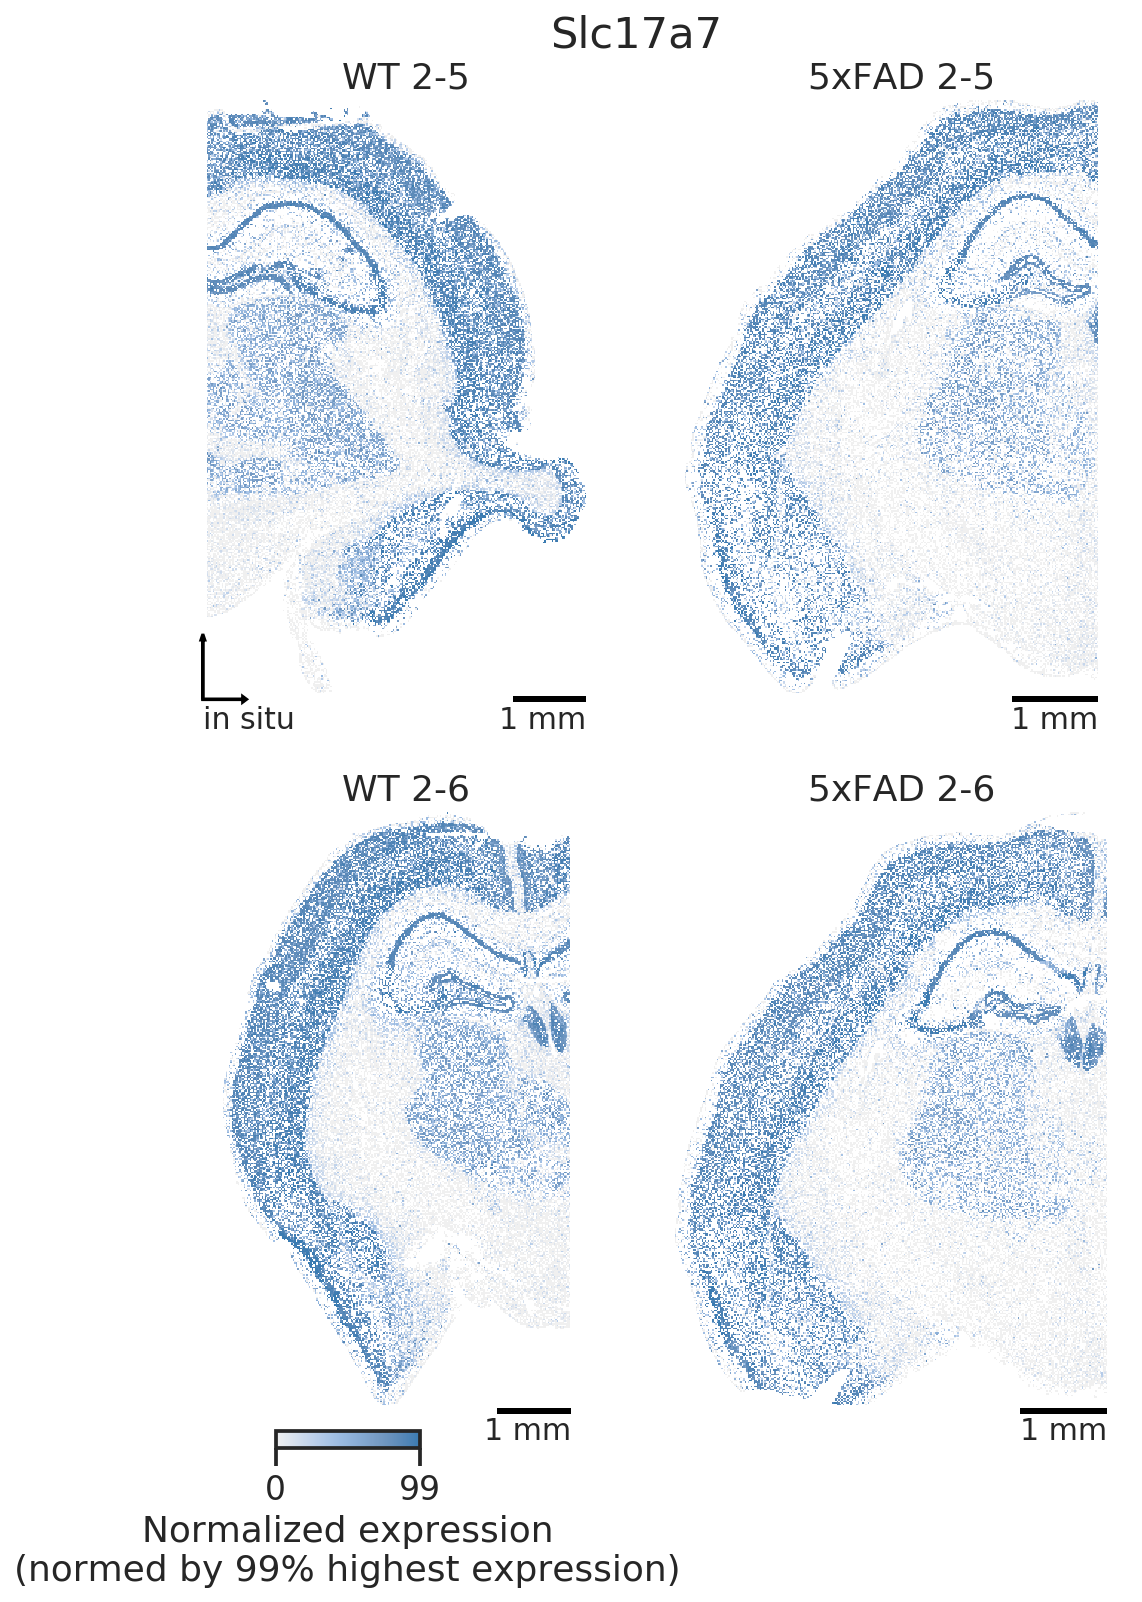

../figures/2021-06-05_AD_mouse_insitu_Slc17a7.pdf


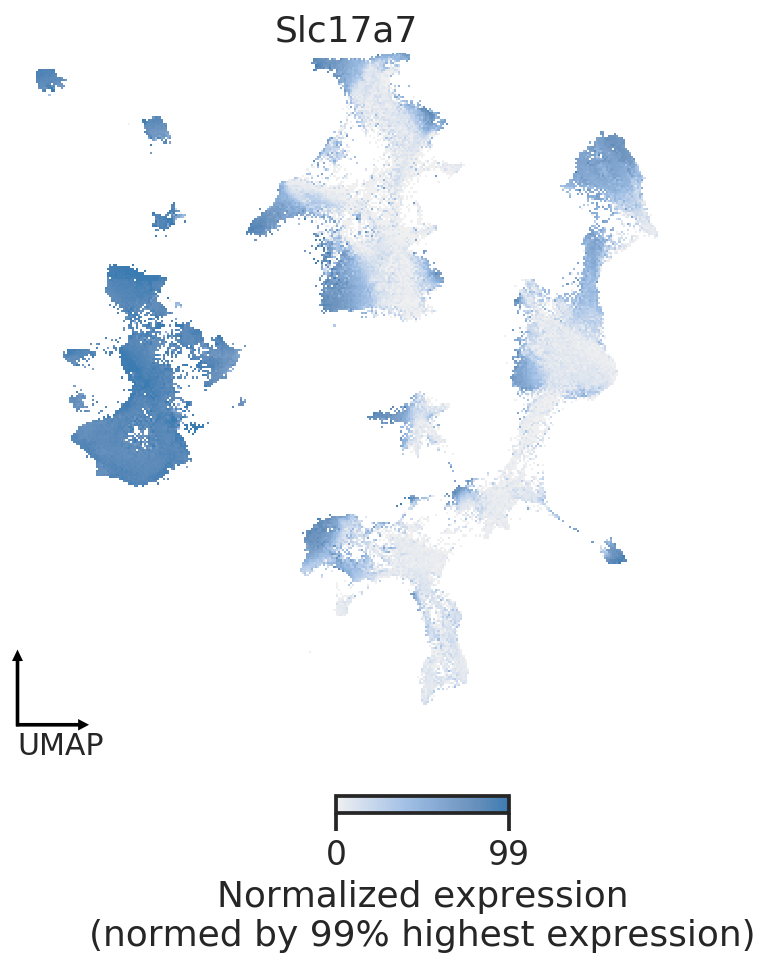

  0%|          | 0/1 [00:05<?, ?it/s]

../figures/2021-06-05_AD_mouse_umap_Slc17a7.pdf


In [8]:
# run genes view
scale_paras = dict(npxly=400)

selected_genes = ['Slc17a7']
for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    output = figures.format("insitu_"+gene+".pdf")
    
    fig_plot_gene_insitu_routine(
        thedatagmat, samples, x, y, hue, 
        samples_annot=samples_annot,
        scale_paras=scale_paras,
        nx=2, ny=2, figsize=(5*2,6*2),
#         close=True,
#         output='', 
        output=output, 
        close=False,
        )
    print(output)
    
    # umap
    x, y, hue = 'umap_1', 'umap_2', gene
    output = figures.format("umap_"+gene+".pdf")
    
    fig_plot_gene_umap_routine(
        thedatagmat, x, y, hue, 
        output=output,
        close=False,
#         close=True,
        )
    print(output)
    break

### Run cluster viz (combined)

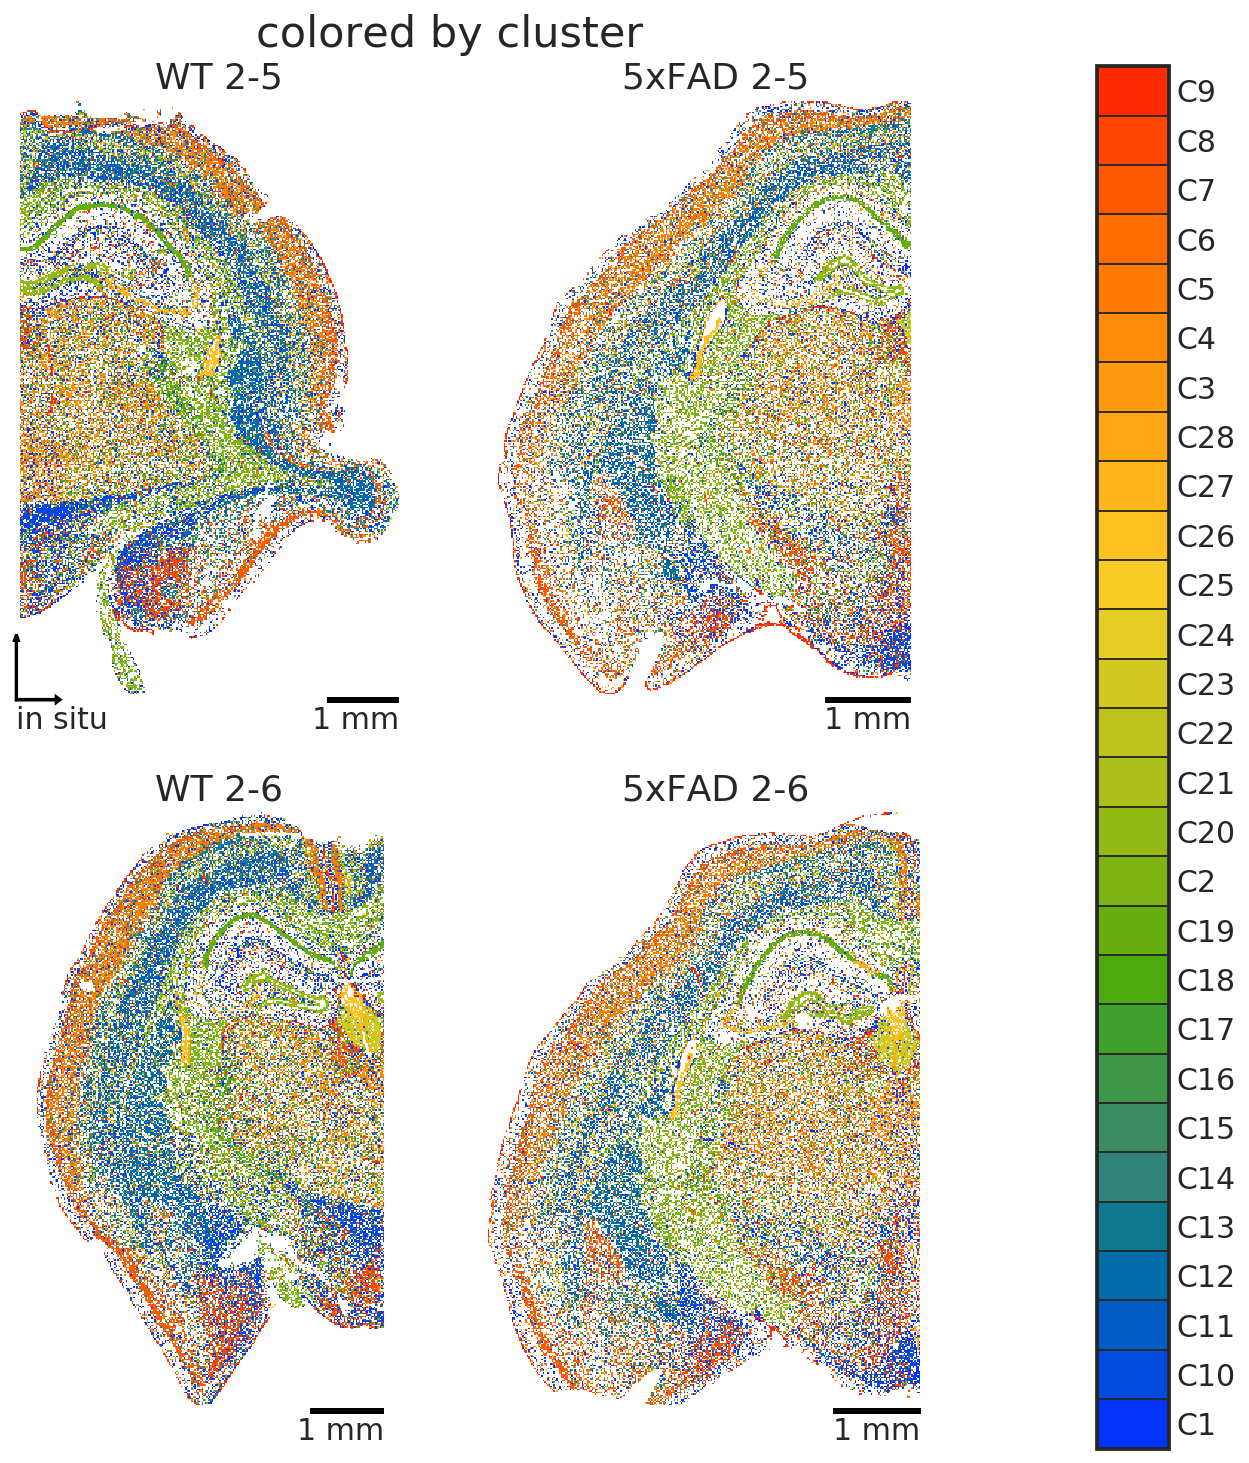

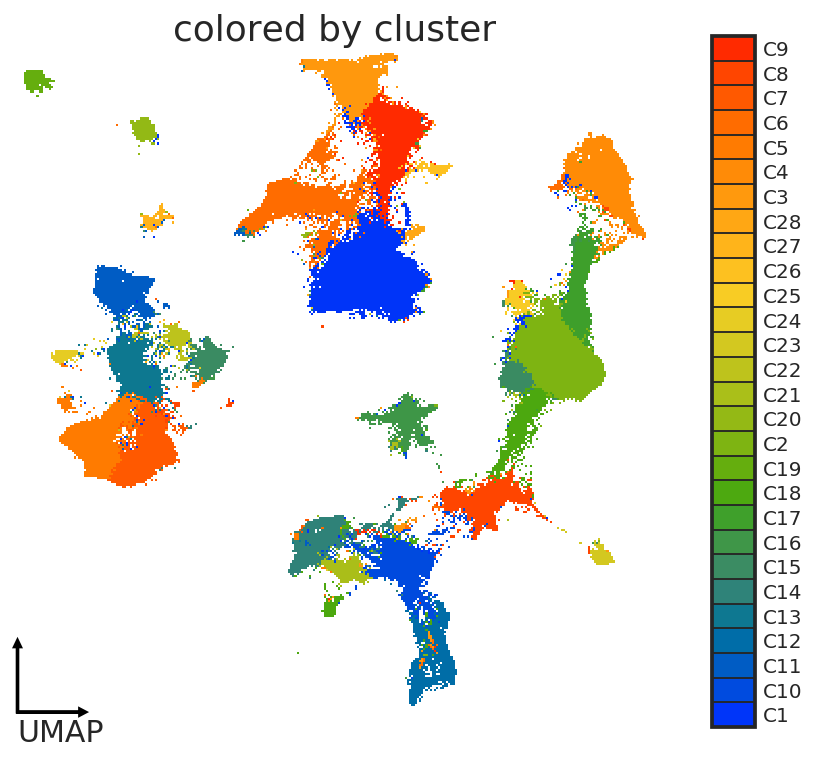

In [9]:
clusters = np.sort(thedata['cluster_cat'].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(clusters)

# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
scale_paras = dict(npxly=400)
suptitle = 'colored by cluster' 
output = figures.format("insitu_allclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    scale_paras=scale_paras,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(5*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by cluster' 
output = figures.format("umap_allclsts"+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

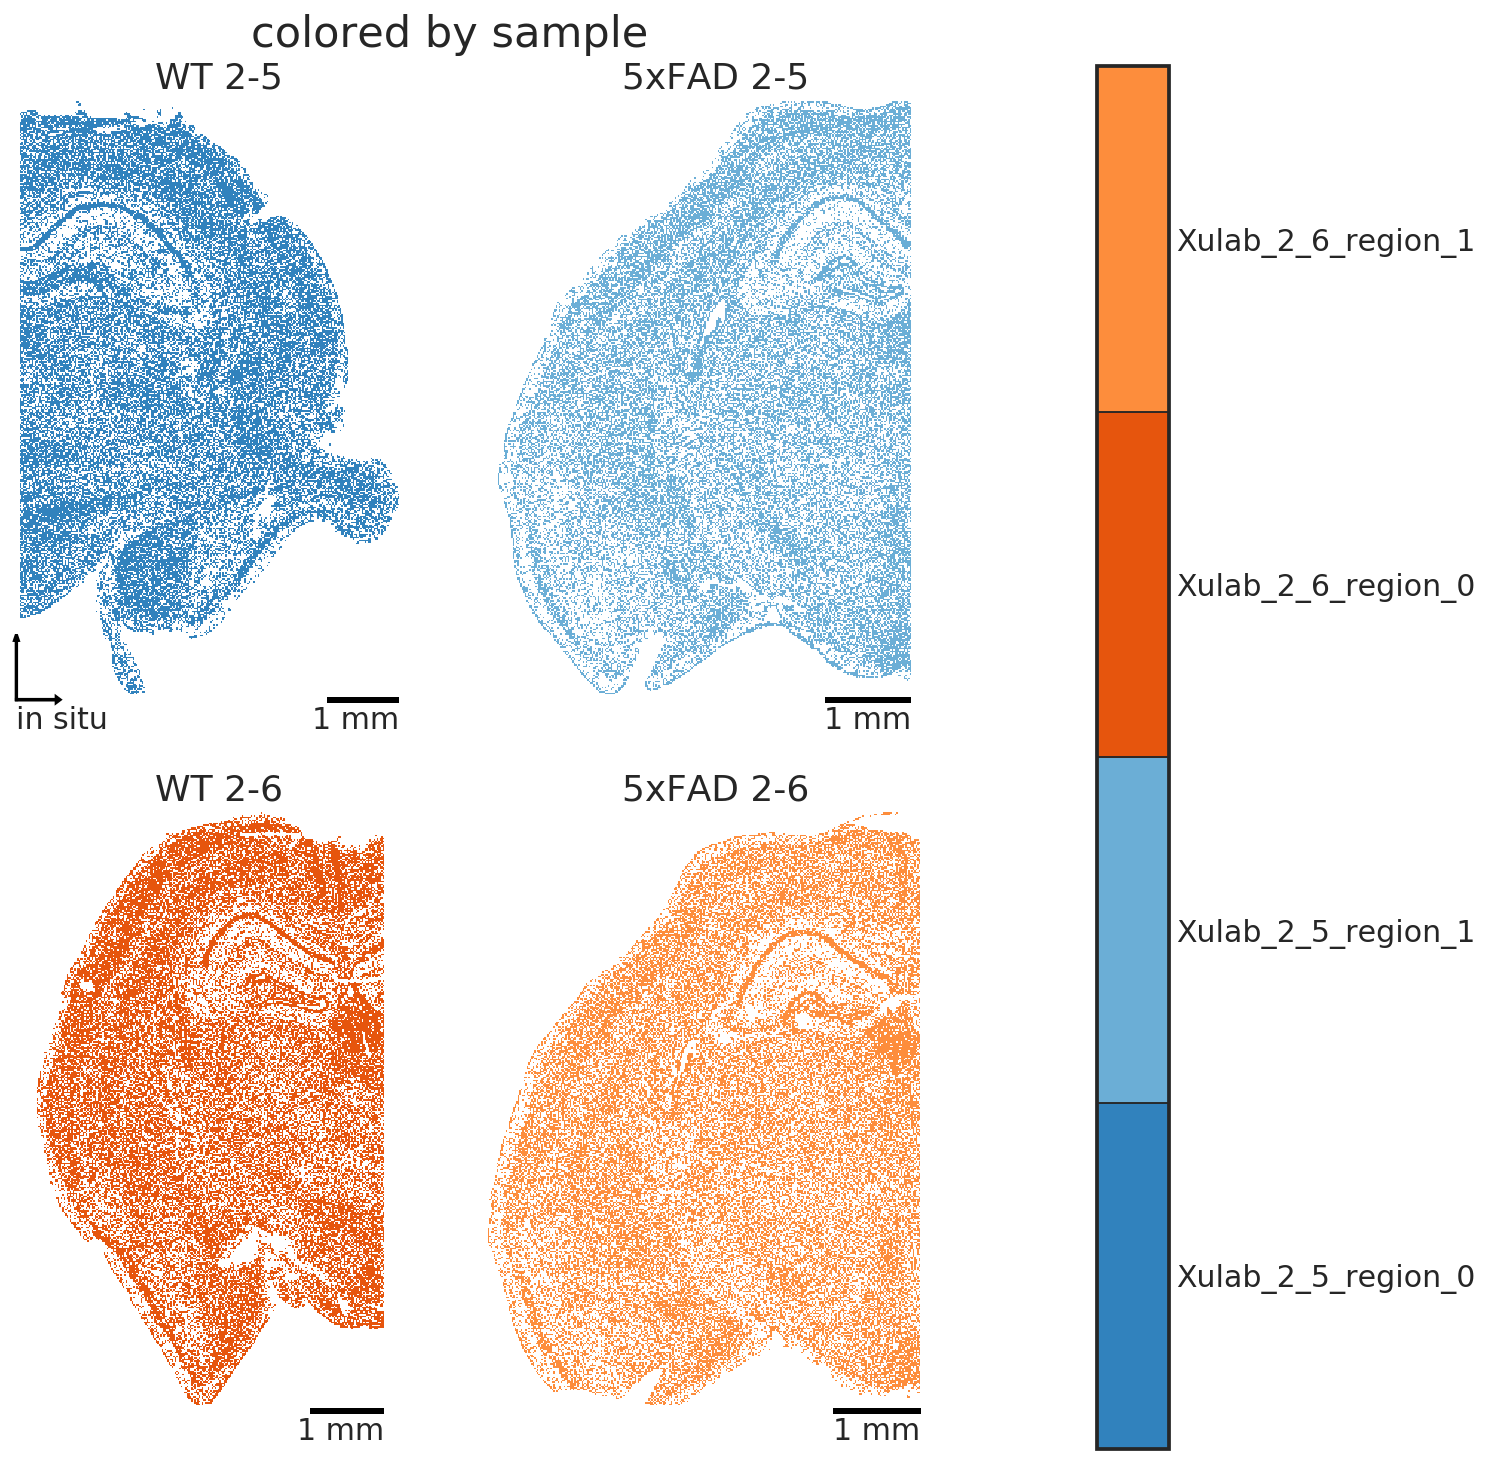

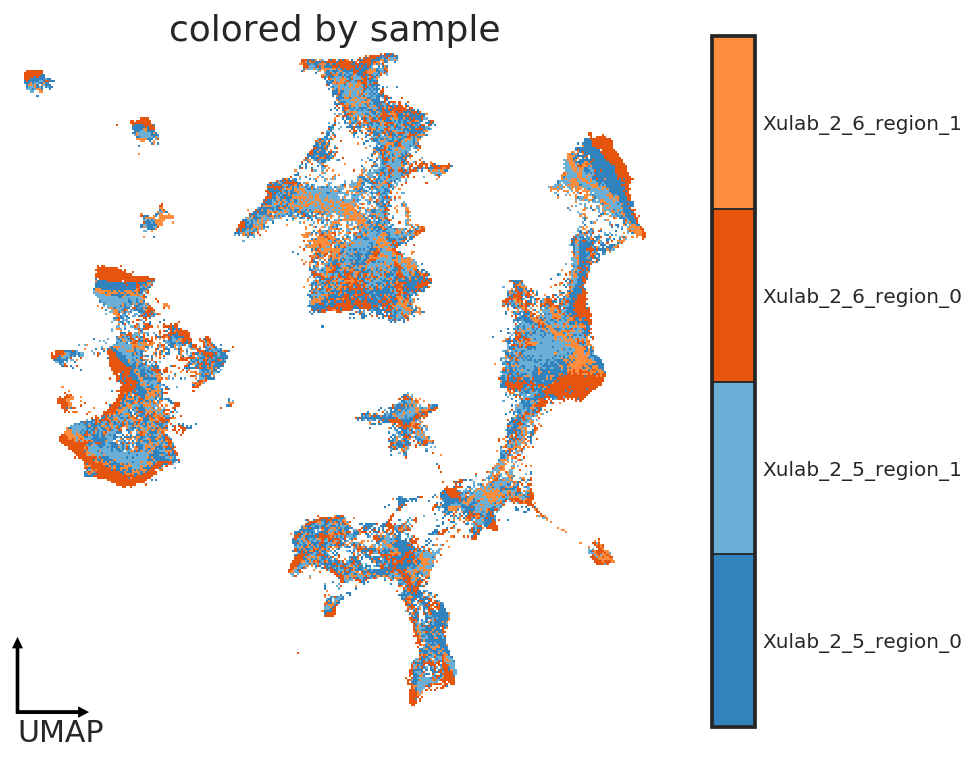

In [10]:
cat_col = 'sample_cat'
thedata[cat_col] = pd.Categorical(thedata['sample'])
categories = np.sort(thedata[cat_col].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(categories, [palette[catg] for catg in categories])

# agg data for each sample
x, y, hue = 'x', 'y', cat_col
scale_paras = dict(npxly=400)
suptitle = 'colored by sample' 
output = figures.format("insitu_allclsts_"+cat_col+".pdf")
close = False
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    scale_paras=scale_paras,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(5*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', cat_col
title = 'colored by sample'
output = figures.format("umap_allclsts_"+cat_col+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

In [11]:
# # selected clusters (preserve colors)
# clstcolors_obj = powerplot.CategoricalColors(
#     clusters)
# colors = clstcolors_obj.colors

# selected_clusters = ['C15', 'C16', 'C19']
# selected_colors = [
#     color if label in selected_clusters else 'lightgray'
#     for color, label in zip(colors, clusters)
# ]
# selected_clstcolors_obj = powerplot.CategoricalColors(
#     clusters, selected_colors,
# )

# selected clusters (not preserve colors)
colors = ['lightgray']*len(clusters)
selected_clusters = ['C19', 'C20', 'C27'] 
selected_colors = powerplot.CategoricalColors(selected_clusters).colors
for i, clst in enumerate(selected_clusters):
    idx = np.where(clusters==clst)[0][0]
    colors[idx] = selected_colors[i]
selected_clstcolors_obj = powerplot.CategoricalColors(clusters, colors)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


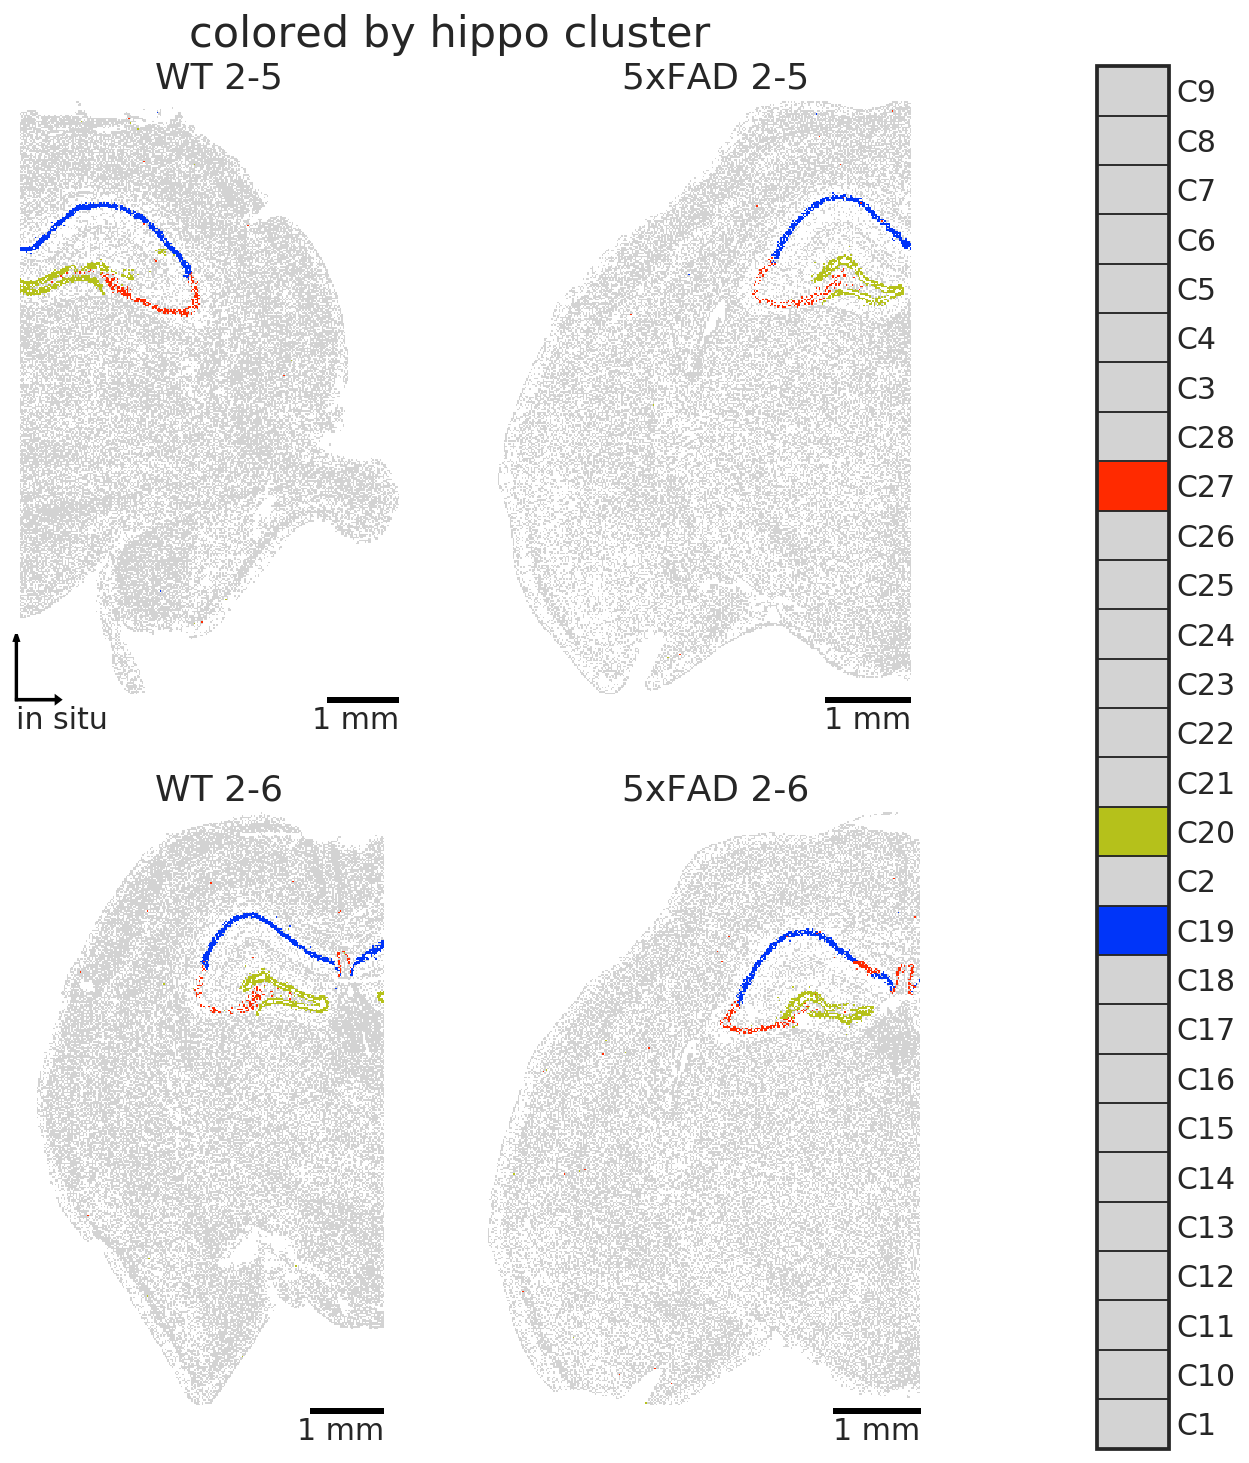

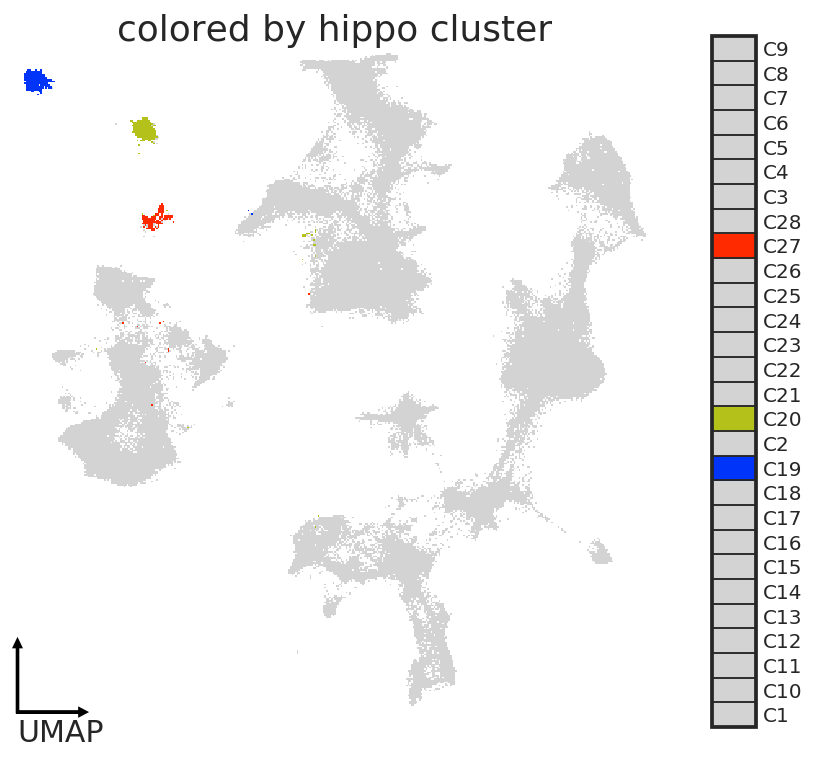

In [12]:

# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
scale_paras = dict(npxly=400)
suptitle = 'colored by hippo cluster' 
output = figures.format("insitu_hippoclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    selected_clstcolors_obj,
    samples_annot=samples_annot,
    scale_paras=scale_paras,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(5*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by hippo cluster' 
output = figures.format("umap_hippoclsts"+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    selected_clstcolors_obj,
    scale_paras=scale_paras,
    title=title,
    close=close,
    output=output,
    )

### Run cluster viz (one-by-one)
- a bit clumsy

In [25]:
# agg data for each sample
ps_aggdata_insitu_allsamples = collections.OrderedDict({})
x, y, hue = 'x', 'y', 'cluster_cat'
# scale_paras = dict(pxl_scale=20)
scale_paras = dict(npxly=400)

# agg data for each sample
for sample in tqdm.tqdm(samples):
    data = thedatagmat[thedatagmat['sample']==sample]
    aggdata, ps, _ = powerplot.agg_count_cat(data, x, y, hue, scale_paras, clip_max=1)
    ps_aggdata_insitu_allsamples[sample] = (aggdata, ps)

100%|██████████| 4/4 [00:00<00:00, 13.94it/s]


0it [00:00, ?it/s]

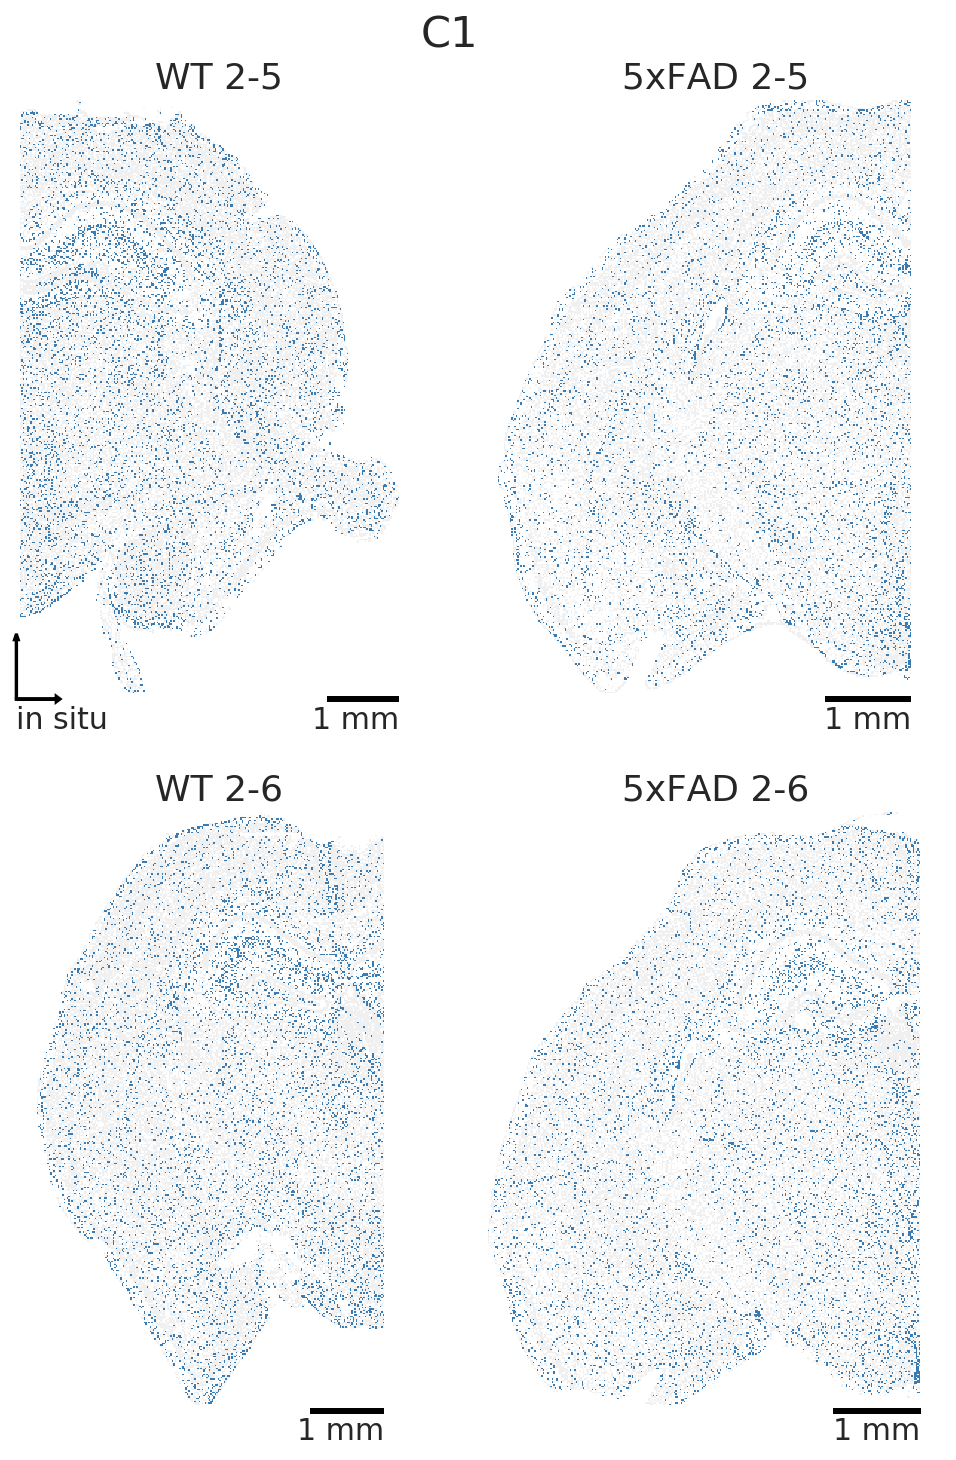

28it [00:46,  1.67s/it]


In [26]:
# then plot for each cluster
nx = 2
ny = 2
figsize=(5*ny,6*nx)
cmap = colorcet.cm.blues
close = True 
clusters = thedatagmat[hue].cat.categories.values

# then plot for each cluster
for k, clst in tqdm.tqdm(enumerate(clusters)):
    if k == 0:
        close = False
    else:
        close = True
    zlabel = clst
    output = figures.format("insitu_"+clst+".png")
    fig, axs = plt.subplots(ny, nx, figsize=figsize)
    for i, (ax, sample) in enumerate(zip(axs.flat, samples)):
        if i == 0:
            configs = dict(
                arrows=True,
                scalebar=True,
                )
        else:
            configs = dict(
                arrows=False,
                scalebar=True,
                )
        title = samples_annot[sample]
        aggdata, ps = ps_aggdata_insitu_allsamples[sample]
        powerplot.plot_cluster_insitu_routine(
            ax, ps, aggdata, 
            hue, zlabel, title, cmap, 
            **configs,
            )
    fig.subplots_adjust(wspace=-0.2)
    fig.suptitle(zlabel, y=0.93)
    
    if output:
        utils.savefig(fig, output)
    if close:
        plt.close()
    else:
        plt.show()
        
#     break

In [27]:
# agg data for each sample
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
scale_paras = dict(npxly=400)
aggdata_umap, ps_umap, _ = powerplot.agg_count_cat(thedatagmat, x, y, hue, scale_paras, clip_max=1)

0it [00:00, ?it/s]

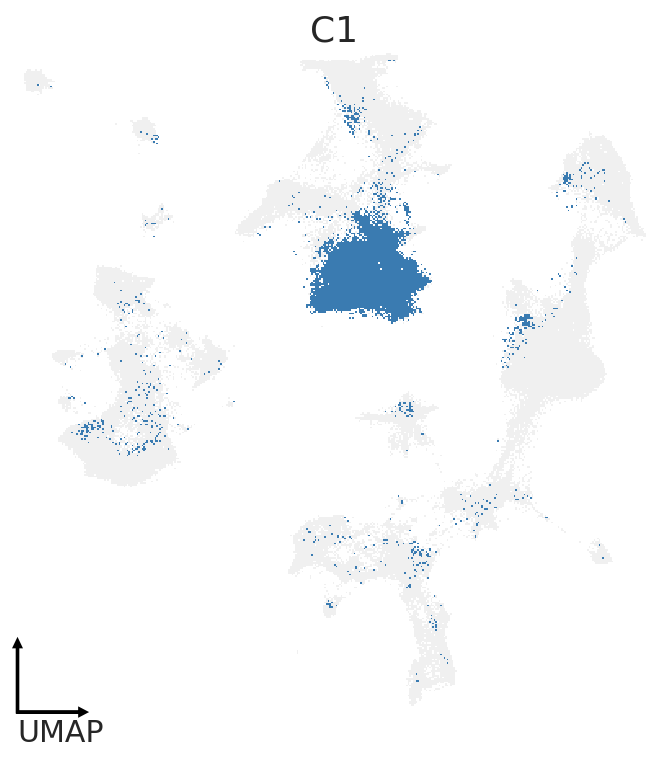

28it [00:15,  1.75it/s]


In [28]:
# then plot for each cluster
figsize=(6,6)
cmap = colorcet.cm.blues
clusters = thedatagmat[hue].cat.categories.values

# then plot for each cluster
for i, clst in tqdm.tqdm(enumerate(clusters)):
    if i == 0:
        close = False
    else:
        close = True
    zlabel = clst
    output = figures.format("umap_"+clst+".png")
    fig, ax = plt.subplots(figsize=figsize)
    title = sample
    ps, aggdata = ps_umap, aggdata_umap
    powerplot.plot_cluster_umap_routine(
        ax, ps, aggdata, 
        hue, zlabel, title, cmap, 
        arrows=True,
        )
    ax.set_title(zlabel)
    
    if output:
        utils.savefig(fig, output)
    if close:
        plt.close()
    else:
        plt.show()
        
#     break

In [17]:
sizemat = thedatagmat.groupby(['cluster', 'sample_name']).size().unstack().fillna(0).astype(int) #.stack()
sizemat['total'] = sizemat.sum(axis=1)
sizemat['frac'] = sizemat.sum(axis=1)/sizemat.sum().sum()
sizemat = sizemat.sort_values('total', ascending=False)
sizemat

sample_name,5xFAD 2-5,5xFAD 2-6,WT 2-5,WT 2-6,total,frac
cluster,,,,,,
C1,6622,7070,7562,6781,28035,0.123860
C2,7378,7044,7157,6084,27663,0.122216
C3,3596,3282,3726,3465,14069,0.062157
C4,2550,3198,4893,2905,13546,0.059847
C5,3216,3314,2716,4154,13400,0.059202
C6,3975,4375,2552,1723,12625,0.055778
C7,2825,3125,3033,2579,11562,0.051081
C8,2880,3073,2336,2796,11085,0.048974
C9,2898,2430,2665,2523,10516,0.046460


In [18]:
sizemat[(sizemat.drop('frac', axis=1) < 100).sum(axis=1) > 0]

sample_name,5xFAD 2-5,5xFAD 2-6,WT 2-5,WT 2-6,total,frac
cluster,,,,,,
C23,145,850,0,864,1859,0.008213


## all gene analyses
- WT vs 5xFAD (2), cell types (N), replicates (2)
- get an heatmap - Ngenes * 4Ncelltypes 

In [19]:
# # select hemi-brain sections
# filter_cond = (
#     ((thedatagmat['sample'] == 'Xulab_2_5_region_0') & (thedatagmat['x'] > 0))
#     | ((thedatagmat['sample'] == 'Xulab_2_5_region_1') & (thedatagmat['x'] < 0))
#     | ((thedatagmat['sample'] == 'Xulab_2_6_region_0') & (thedatagmat['x'] < 0))
#     | ((thedatagmat['sample'] == 'Xulab_2_6_region_1') & (thedatagmat['x'] < 0))
# )

# select clusters with >100 cells in each hemi-slice
filter_cond = (
    (~thedatagmat['cluster'].isin(['C23']))
)

# selecteddata
selecteddata = thedatagmat[filter_cond]

# mean, std, n, zscore 
gmat_mean = selecteddata.groupby(['cluster', 'sample_name']).mean()[genes]
gmat_std = selecteddata.groupby(['cluster', 'sample_name']).std()[genes]
gmat_n = selecteddata.groupby(['cluster', 'sample_name']).count()[genes]
gmat_meanz = (gmat_mean - gmat_mean.mean())/gmat_mean.std()

# celltypes
celltypes = gmat_mean.index.levels[0].values

print(thedatagmat.shape, selecteddata.shape)
print(gmat_mean.shape, gmat_std.shape, gmat_n.shape, gmat_meanz.shape)

(226345, 168) (224486, 168)
(108, 150) (108, 150) (108, 150) (108, 150)


In [20]:
# mean diff and statistical significant diff
diff1 = (gmat_meanz.query('sample_name == "5xFAD 2-5"').droplevel(level=1)
         - gmat_meanz.query('sample_name == "WT 2-5"').droplevel(level=1)
        ).loc[celltypes]
diff1['slice'] = "2-5"
diff1 = diff1.set_index('slice', append=True)

diff2 = (gmat_meanz.query('sample_name == "5xFAD 2-6"').droplevel(level=1)
         - gmat_meanz.query('sample_name == "WT 2-6"').droplevel(level=1)
        ).loc[celltypes]
diff2['slice'] = "2-6"
diff2 = diff2.set_index('slice', append=True)

diffmat = pd.concat([diff1, diff2]).sort_index(level=0)
print(diffmat.shape)

# sig diff
alpha = 0.05

ctrl, case = 'WT 2-5', '5xFAD 2-5'

query_ctrl = 'sample_name == "{}"'.format(ctrl)
query_case = 'sample_name == "{}"'.format(case)
t, p = stats.ttest_ind_from_stats(
    gmat_mean.query(query_ctrl).loc[celltypes].values,
    gmat_std.query(query_ctrl).loc[celltypes].values,
    gmat_n.query(query_ctrl).loc[celltypes].values,
    gmat_mean.query(query_case).loc[celltypes].values,
    gmat_std.query(query_case).loc[celltypes].values,
    gmat_n.query(query_case).loc[celltypes].values,
)
p[np.isnan(p)] = 1
q = utils.get_fdr(p.reshape(-1)).reshape(p.shape)
q = pd.DataFrame(q, index=celltypes, columns=genes)
q['slice'] = "2-5"
q = q.set_index('slice', append=True)
rej = q<alpha

q1 = q
rej1 = rej

ctrl, case = 'WT 2-6', '5xFAD 2-6'

query_ctrl = 'sample_name == "{}"'.format(ctrl)
query_case = 'sample_name == "{}"'.format(case)
t, p = stats.ttest_ind_from_stats(
    gmat_mean.query(query_ctrl).loc[celltypes].values,
    gmat_std.query(query_ctrl).loc[celltypes].values,
    gmat_n.query(query_ctrl).loc[celltypes].values,
    gmat_mean.query(query_case).loc[celltypes].values,
    gmat_std.query(query_case).loc[celltypes].values,
    gmat_n.query(query_case).loc[celltypes].values,
)
p[np.isnan(p)] = 1
q = utils.get_fdr(p.reshape(-1)).reshape(p.shape)
q = pd.DataFrame(q, index=celltypes, columns=genes)
q['slice'] = "2-6"
q = q.set_index('slice', append=True)
rej = q<alpha

q2 = q
rej2 = rej

qmat = pd.concat([q1, q2]).sort_index(level=0)
rejmat = pd.concat([rej1, rej2]).sort_index(level=0)
# rejmat

(54, 150)


../figures/2021-06-05_AD_mouse_gene_by_clusters.pdf


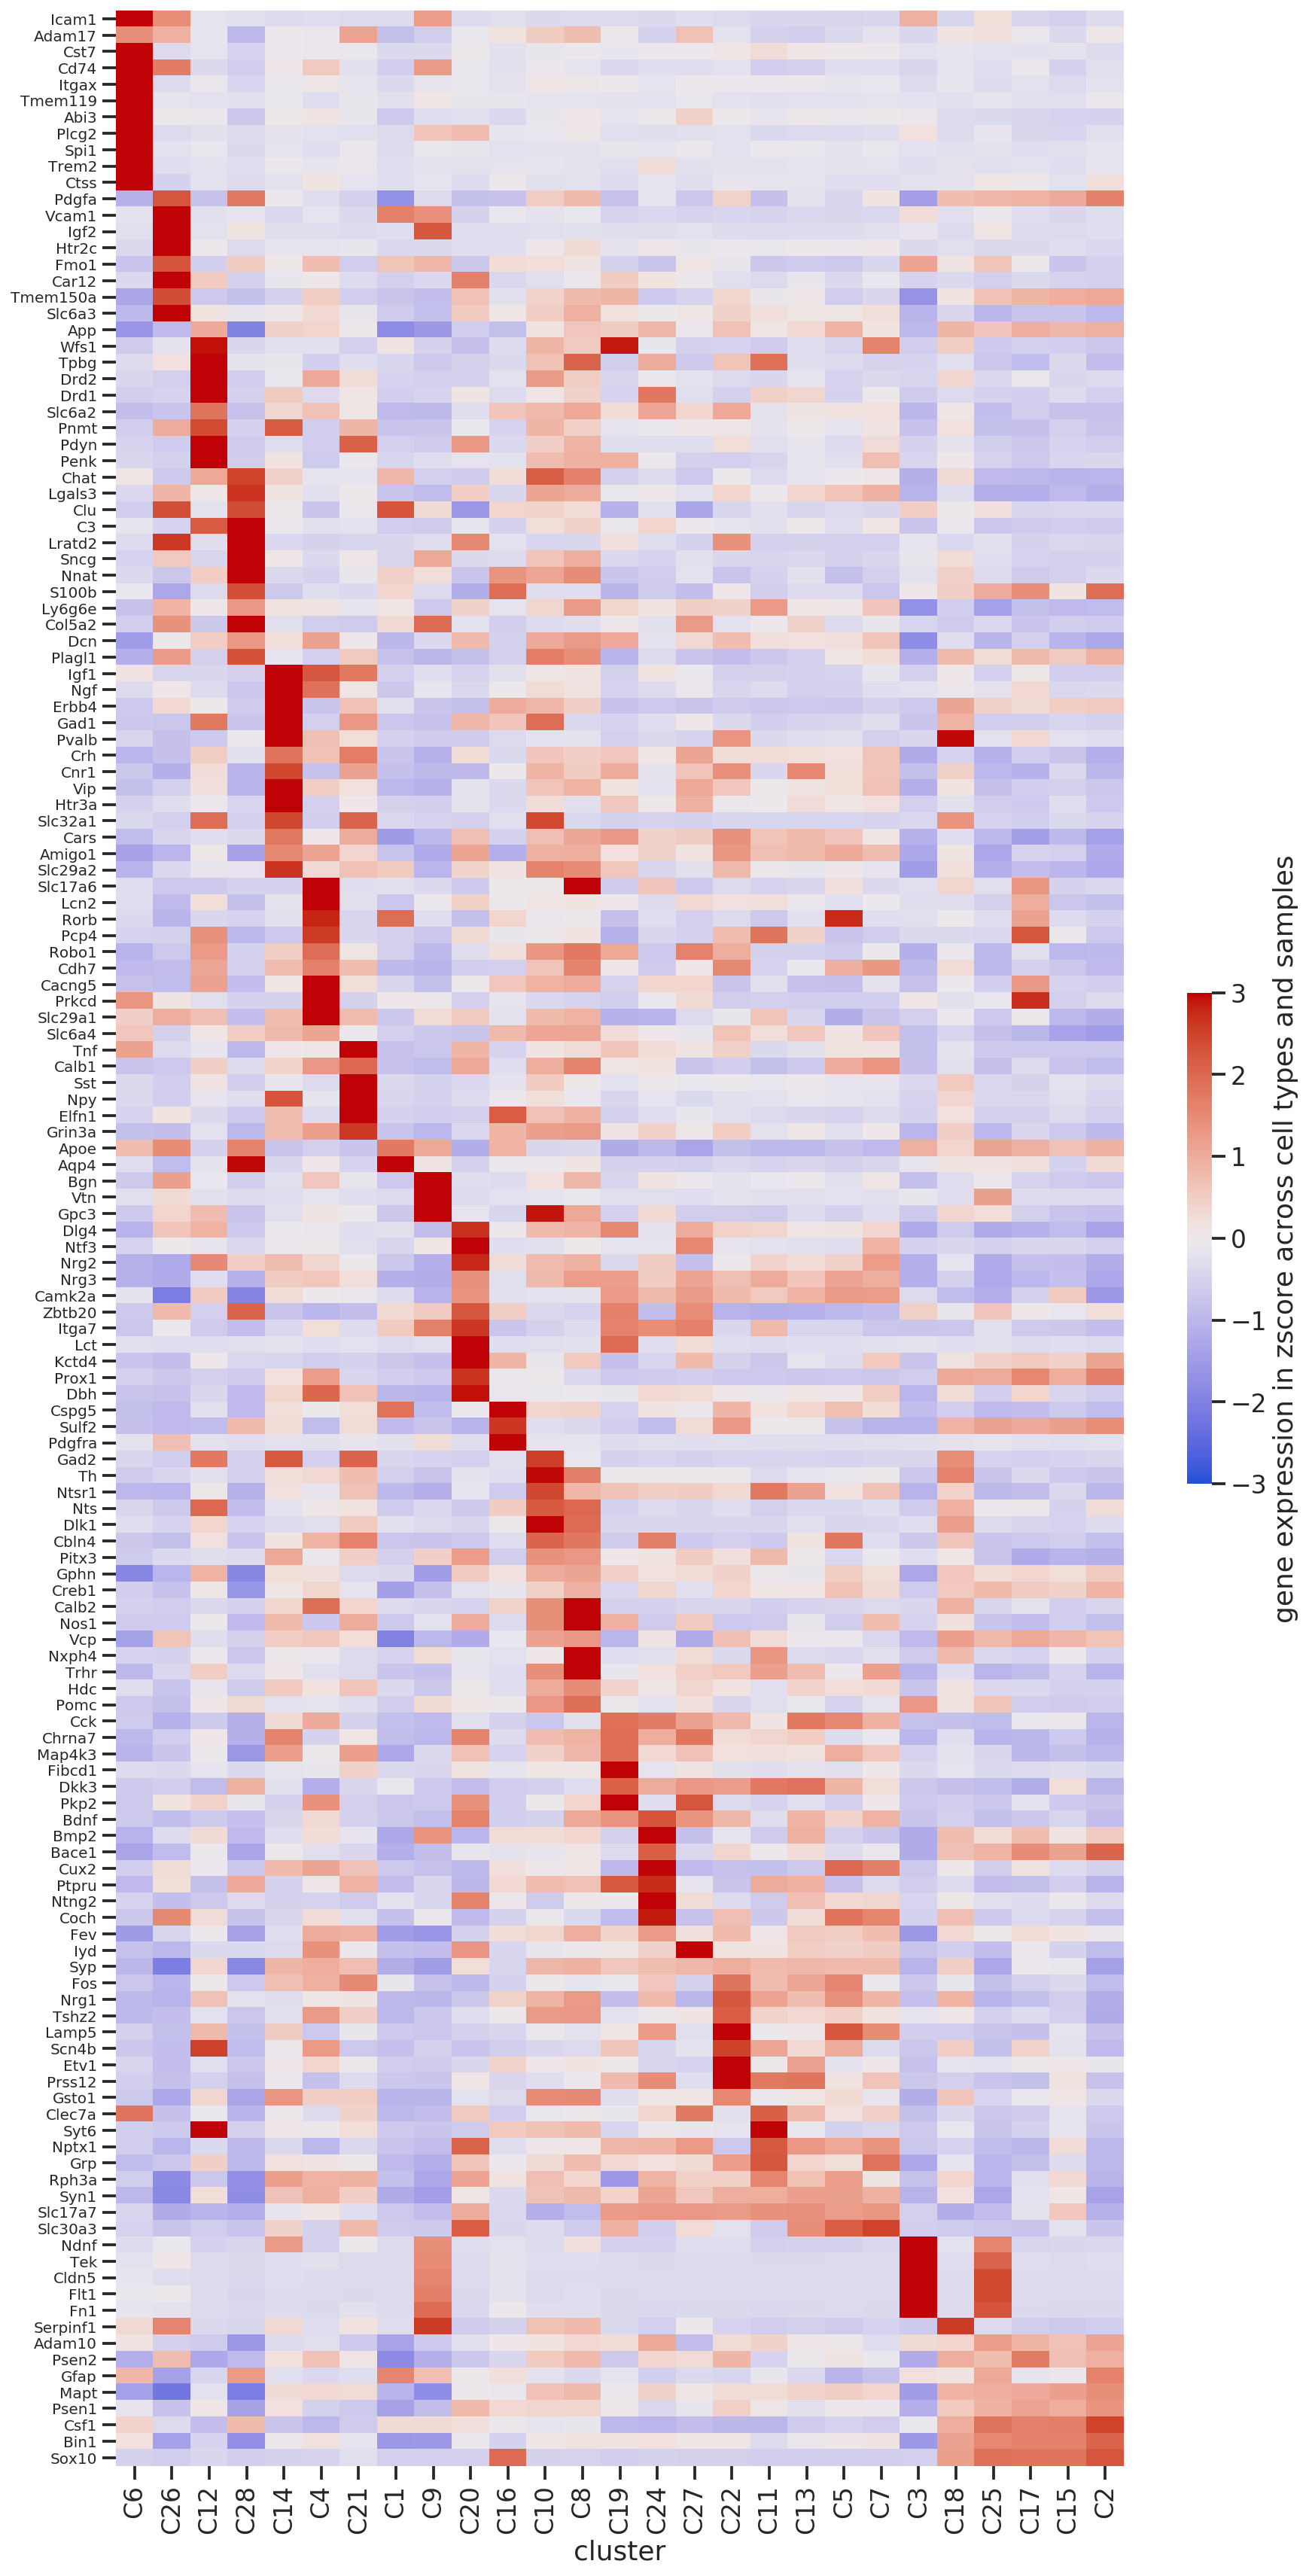

In [21]:
output = figures.format("gene_by_clusters.pdf")

heatmat = gmat_meanz.T.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx = utils.diag_matrix(heatmat.values, threshold=1)

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order = utils.get_order_from_hierarchy(heatmat.T) # by cluster; collapse slices

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat.iloc[:,col_order].values)

fig, ax = plt.subplots(figsize=(15, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell types and samples'),
    rasterized=True,
   )
# ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

utils.savefig(fig, output)
print(output)
plt.show()


../figures/2021-06-05_AD_mouse_gene_by_clusters_separate_samples.pdf


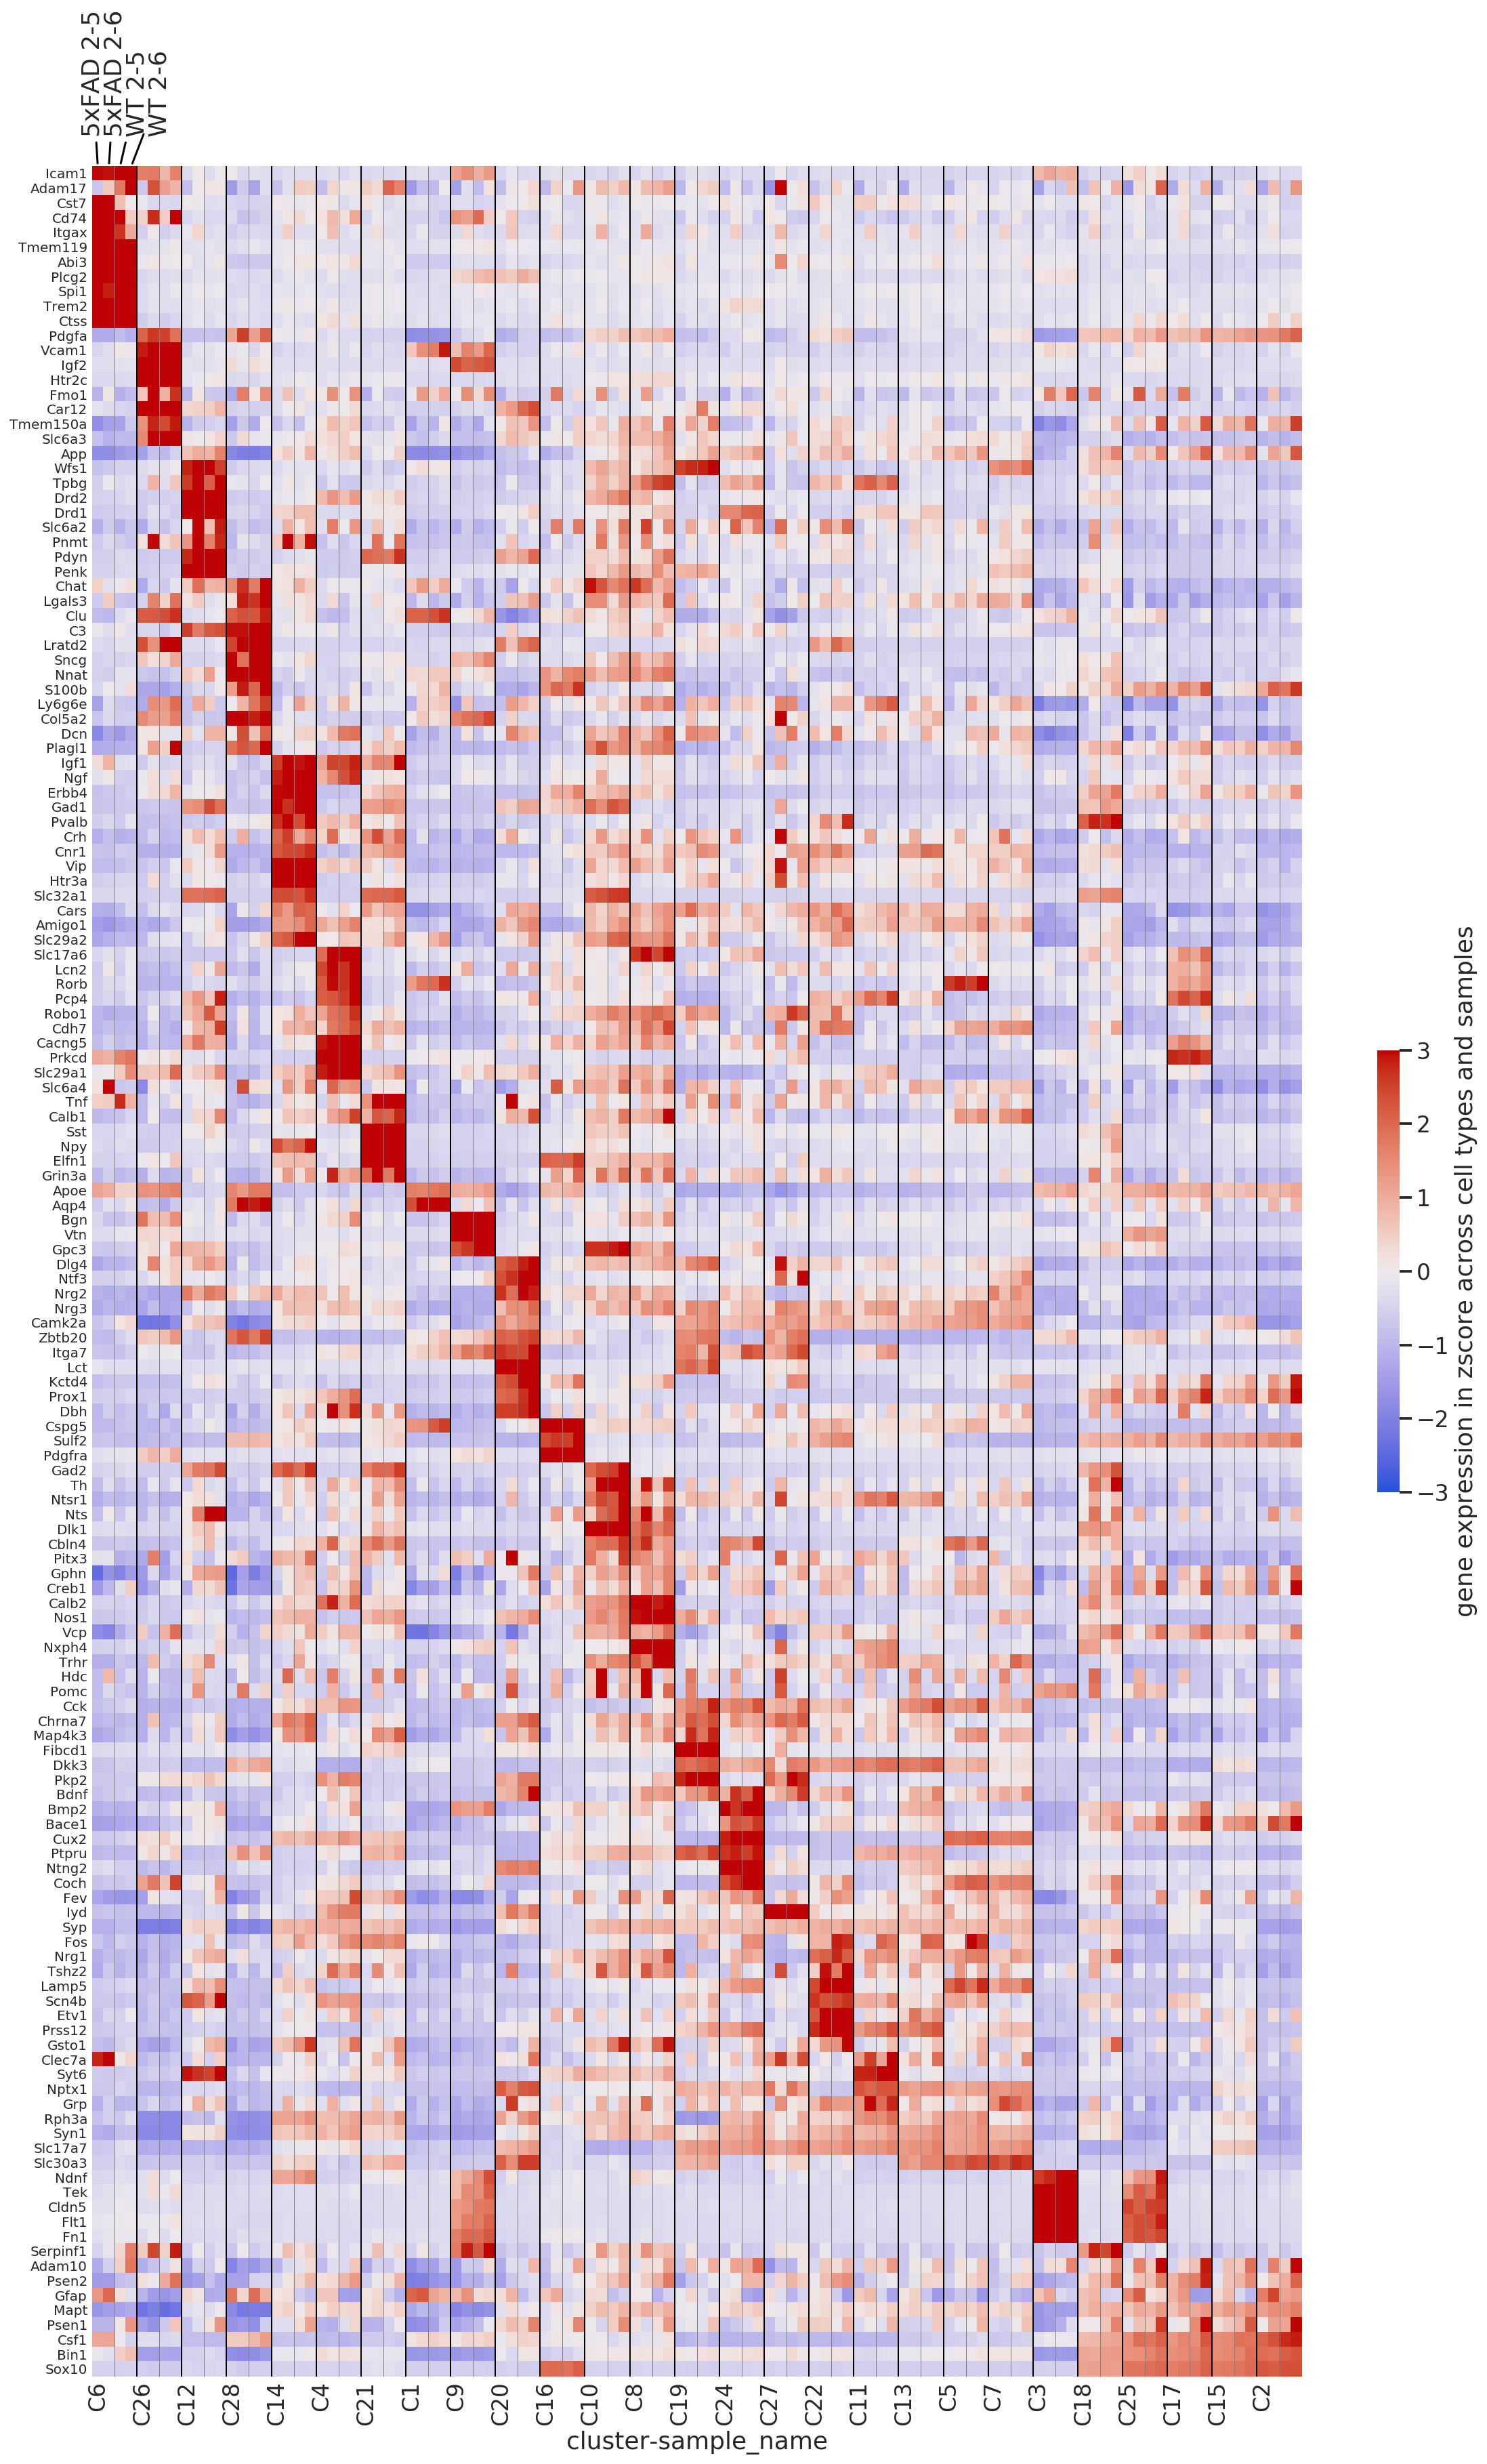

In [22]:
output = figures.format("gene_by_clusters_separate_samples.pdf")

heatmat = gmat_meanz.T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([4*col+np.array([0,1,2,3]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([4*col+np.array([0,1,2,3]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell types and samples'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(4): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.vlines(np.arange(0, ncol, 4)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)
ax.vlines(np.arange(2, ncol, 4), 0, nrow, color='gray', linewidth=0.5, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

cluster_orders = col_order_reduced

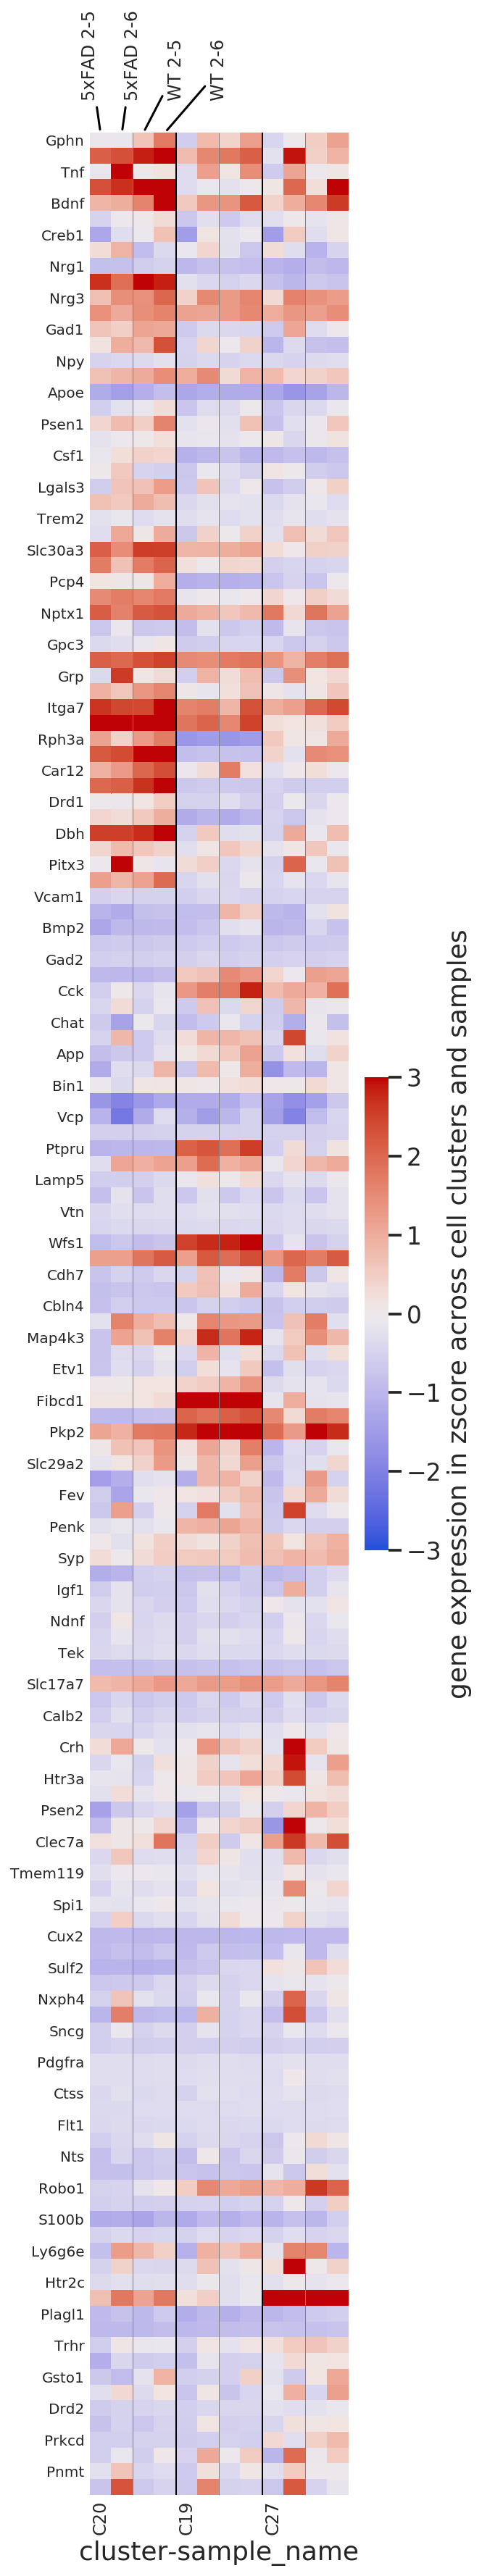

In [23]:
heatmat = gmat_meanz.loc[selected_clusters].T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = snmcseq_utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([4*col+np.array([0,1,2,3]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([4*col+np.array([0,1,2,3]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(4, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order],
#     heatmat.iloc[rowidx, colidx],
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    cmap=colorcet.coolwarm,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell clusters and samples'),
    ax=ax,
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp, fontsize=12)
for i in range(4): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
                fontsize=12,
               )


ax.vlines(np.arange(0, ncol, 4)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)
ax.vlines(np.arange(2, ncol, 4), 0, nrow, color='gray', linewidth=0.5, clip_on=False)
plt.show()

In [ ]:
output = figures.format("gene_diff_5xFAD_vs_WT.pdf")

heatmat = (rejmat*diffmat).T

nrow, ncol = heatmat.shape
heatmat_reduced = heatmat.mean(level=0, axis=1)

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([2*col+np.array([0,1,]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([2*col+np.array([0,1,]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,col_order_reduced].abs().values)

_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,cluster_orders].abs().values)

# order4
colidx_v4 = np.hstack([2*col+np.array([0,1,]) for col in cluster_orders])


# order5
rowidx_v5 = np.argsort(heatmat.sum(axis=1))



fig, ax = plt.subplots(figsize=(15, 30))
sns.heatmap(
    heatmat.iloc[rowidx_v5, colidx_v4], 
#     heatmat.iloc[row_order, colidx_v4], 
#     heatmat.iloc[rowidx_v3, colidx_v4],
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
#     heatmat.iloc[rowidx_v3, col_order], 
#     heatmat,
    
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='5xFAD-WT in zscore\n(only elements with FDR<0.05 are shown)'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(2): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.set_xlabel('cell clusters and slices')
ax.vlines(np.arange(0, ncol, 2)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

../figures/2021-06-05_AD_mouse_gene_diff_5xFAD_vs_WT.pdf
